In [46]:
from dataclasses import dataclass, field
from prettytable import PrettyTable
from textwrap import fill
from typing import Tuple
import matplotlib.pyplot as plt
import numpy as np
import random

In [47]:
@dataclass
class FinancialConfig(object):
    SEMESTER_WEEKS: int = 16
    MONTHLY_INCOME: int = 400_000
    SAVINGS: int = 100_000

    INCOME_VARIABILITY: float = 0.2
    EXTRA_INCOME_PROBABILITY: float = 0.01
    EXTRA_INCOME_RANGE: Tuple[int, int] = (int(MONTHLY_INCOME * 0.125), int(MONTHLY_INCOME * 0.25))

    WEEK_DAYS: int = 5
    LUNCH_PRICE: int = 16_500
    TRANSPORT_FARE: int = 3_400
    SNACK_PRICE_RANGE: Tuple[int, int] = (5_000, 15_000)

    LUNCHES_PER_WEEK: int = 3
    BUY_SNACK: bool = True
    SNACK_PROBABILITY: float = 0.5
    TRANSPORT_DAYS: int = WEEK_DAYS - 0

    EXTRA_EXPENSES_PROBABILITY: float = 0.4
    EXTRA_EXPENSES_RANGE: Tuple[int, int] = (50_000, 100_000)
    
    EMERGENCY_EXPENSES_PROBABILITY: float = 0.1
    EMERGENCY_RANGE: Tuple[int, int] = (100_000, 300_000)

    INFLATION_RATE: float = 0.02

In [ ]:
@dataclass
class FinancialEvolution(object):
    config: FinancialConfig
    weeks: np.ndarray = field(default_factory=lambda: np.array([]))
    cumulative_income: np.ndarray = field(default_factory=lambda: np.array([]))
    cumulative_expenses: np.ndarray = field(
        default_factory=lambda: np.array([]))
    available_balance: np.ndarray = field(default_factory=lambda: np.array([]))

    def simulate_income(self, month: int) -> float:
        base_income = self.config.MONTHLY_INCOME
        inflated_income = base_income * \
            (1 + self.config.INFLATION_RATE) ** month
        variability = 1 + \
            random.uniform(-self.config.INCOME_VARIABILITY,
                           self.config.INCOME_VARIABILITY)
        varied_income = inflated_income * variability

        if random.random() < self.config.EXTRA_INCOME_PROBABILITY:
            extra = random.randint(*self.config.EXTRA_INCOME_RANGE)
            varied_income += extra

        return varied_income

    def simulate_weekly_expenses(self, week: int, month: int) -> float:
        # Base Expenses
        base_expenses: float = 0

        # Lunches
        base_expenses += self.config.LUNCHES_PER_WEEK * self.config.LUNCH_PRICE

        # Transport (considering it's not everyday)
        actual_transport_days = min(
            random.randint(self.config.TRANSPORT_DAYS - 1,
                           self.config.TRANSPORT_DAYS + 1),
            self.config.WEEK_DAYS
        )
        base_expenses += actual_transport_days * self.config.TRANSPORT_FARE * 2

        # Snacks
        if self.config.BUY_SNACK:
            for _ in range(self.config.WEEK_DAYS):
                if random.random() < self.config.SNACK_PROBABILITY:
                    snack_price = random.uniform(
                        *self.config.SNACK_PRICE_RANGE)
                    base_expenses += snack_price

        # Extra Expenses
        if random.random() < self.config.EXTRA_EXPENSES_PROBABILITY:
            base_expenses += random.randint(*self.config.EXTRA_EXPENSES_RANGE)

        # Emergency Expenses
        if random.random() < self.config.EMERGENCY_EXPENSES_PROBABILITY:
            base_expenses += random.randint(*self.config.EMERGENCY_RANGE)

        inflation_factor = (1 + self.config.INFLATION_RATE) ** (month / 3)
        return base_expenses * inflation_factor

    def run_simulation(self) -> None:
        self.weeks = np.arange(self.config.SEMESTER_WEEKS + 1)
        self.cumulative_income = np.zeros(self.config.SEMESTER_WEEKS + 1)
        self.cumulative_expenses = np.zeros(self.config.SEMESTER_WEEKS + 1)

        self.cumulative_income[0] = self.config.SAVINGS

        for month in range(int(self.config.SEMESTER_WEEKS / 4)):
            week_index = month * 4
            if week_index <= self.config.SEMESTER_WEEKS:
                monthly_income = self.simulate_income(month=month)
                self.cumulative_income[week_index:] += monthly_income

        for week in range(1, self.config.SEMESTER_WEEKS + 1):
            current_month = week // 4
            weekly_expense = self.simulate_weekly_expenses(
                week=week, month=current_month)
            self.cumulative_expenses[week] = self.cumulative_expenses[week -
                                                                      1] + weekly_expense

        self.available_balance = self.cumulative_income - self.cumulative_expenses

    def plot_results(self) -> plt.Figure:
        figure = plt.figure(figsize=(20, 6))

        # Main Plots
        plt.plot(self.weeks, self.cumulative_income, 'g-o',
                 label='Ingresos Acumulados', linewidth=2)
        plt.plot(self.weeks, self.cumulative_expenses, 'r--o',
                 label='Gastos Acumulados', linewidth=2)

        # Superavit-Deficit Areas
        plt.fill_between(self.weeks, self.available_balance, where=(self.available_balance >= 0),
                         facecolor='lightgreen', alpha=0.5, label='Superávit')
        plt.fill_between(self.weeks, self.available_balance, where=(self.available_balance < 0),
                         facecolor='salmon', alpha=0.5, label='Déficit')

        # [0] line
        plt.axhline(0, color='black', linestyle='-', linewidth=1.5, zorder=3)

        # Ticks Configuration
        y_min = min(self.available_balance)
        y_max = max(self.cumulative_income) + 100_000
        step = max(200_000, (y_max - y_min) // 5)

        y_ticks = np.arange(round(y_min / step) * step, y_max + step, step)
        plt.yticks(y_ticks,
                   labels=[f"${x/1000:.0f}k" for x in y_ticks],
                   fontsize=10)
        plt.ylim(y_ticks[0], y_ticks[-1])

        # Bankruptcy Marker
        bankruptcy_week = np.argmax(self.available_balance < 0)
        if bankruptcy_week > 0:
            plt.axvline(x=bankruptcy_week, color='darkred',
                        linestyle=':', alpha=0.7)
            plt.annotate(f'QUIEBRA\nSemana {bankruptcy_week}',
                         (bankruptcy_week, 0),
                         xytext=(bankruptcy_week, -
                                 max(abs(self.available_balance))/3),
                         bbox=dict(boxstyle="round,pad=0.5", fc="red", ec="black",
                                   lw=1, alpha=0.8),
                         color='white',
                         fontweight='bold',
                         ha='center',
                         arrowprops=dict(arrowstyle="->",
                                         color='red',
                                         linewidth=2,
                                         connectionstyle="arc3,rad=-0.2"))

        # Styling
        plt.title('Simulación Financiera Universitaria - Análisis de Solvencia',
                  fontsize=16, pad=20)
        plt.xlabel('Semanas del Semestre', fontsize=12)
        plt.ylabel('Balance Acumulado ($)', fontsize=12)
        plt.xticks(range(0, self.config.SEMESTER_WEEKS + 1, 1),
                   labels=[f"[{i}]" for i in range(
                       0, self.config.SEMESTER_WEEKS + 1)],
                   )

        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.tight_layout()

        return figure

    def generate_report(self) -> PrettyTable:
        report = PrettyTable()
        report.title = "REPORTE FINANCIERO SEMESTRAL"
        report.align = "l"
        report.field_names = ["Métrica", "Valor", "Detalle"]

        # Calculate Key Metrics
        final_balance = self.available_balance[-1]
        total_income = self.cumulative_income[-1]
        total_expenses = self.cumulative_expenses[-1]
        bankruptcy_week = np.argmax(self.available_balance < 0)
        avg_weekly_expense = np.mean(np.diff(self.cumulative_expenses[1:]))
        max_deficit = min(self.available_balance) if any(
            self.available_balance < 0) else 0

        # Financial Study
        financial_status = "EN QUIEBRA" if bankruptcy_week > 0 else "SOLVENTE"
        if bankruptcy_week > 0:
            financial_status += f" (Semana {bankruptcy_week})"

        # Adding Rows...
        report.add_row(["Estado Financiero",
                        financial_status,
                        "Situación al final del semestre"])

        report.add_row(["Balance Final",
                        f"${final_balance:,.0f}",
                        "Ingresos - Gastos totales"])

        report.add_row(["Ingresos Totales",
                        f"${total_income:,.0f}",
                        f"Incluye {self.config.MONTHLY_INCOME:,.0f}/mes + extras"])

        report.add_row(["Gastos Totales",
                        f"${total_expenses:,.0f}",
                        f"Promedio semanal: ${avg_weekly_expense:,.0f}"])

        report.add_row(["Máximo Déficit",
                        f"${max_deficit:,.0f}" if max_deficit < 0 else "N/A",
                        "Valor más negativo alcanzado"])

        # Analysis of Expenses Components
        expense_composition = " \n ".join([
            f"Almuerzos: {self.config.LUNCHES_PER_WEEK}x/sem × ${self.config.LUNCH_PRICE:,.0f}",
            f"Transporte: {self.config.TRANSPORT_DAYS}d/sem × ${self.config.TRANSPORT_FARE*2:,.0f} (ida/vuelta)",
            f"Meriendas: {'Sí' if self.config.BUY_SNACK else 'No'} (${self.config.SNACK_PRICE_RANGE[0]:,.0f}-{self.config.SNACK_PRICE_RANGE[1]:,.0f})",
            f"Gastos extras: {self.config.EXTRA_EXPENSES_PROBABILITY*100:.0f}% prob (${self.config.EXTRA_EXPENSES_RANGE[0]:,.0f}-{self.config.EXTRA_EXPENSES_RANGE[1]:,.0f})",
            f"Emergencias: {self.config.EMERGENCY_EXPENSES_PROBABILITY*100:.0f}% prob (${self.config.EMERGENCY_RANGE[0]:,.0f}-{self.config.EMERGENCY_RANGE[1]:,.0f})"
        ])

        report.add_row(["Composición de Gastos",
                        fill(expense_composition, width=40),
                        "Estructura de costos semanales"])

        # Recommendations
        recommendations = []
        if bankruptcy_week > 0:
            recommendations.append("Reducir gastos variables")
            recommendations.append("Buscar ingresos adicionales")
        if avg_weekly_expense > self.config.MONTHLY_INCOME/4:
            recommendations.append("Gastos semanales muy altos vs ingresos")
        if not self.config.SAVINGS:
            recommendations.append("Considerar ahorros iniciales")

        if recommendations:
            report.add_row(["Recomendaciones",
                            "\n".join(recommendations),
                            "Acciones sugeridas"])

        return report

In [49]:
config = FinancialConfig()
financial_evolution = FinancialEvolution(config=config)

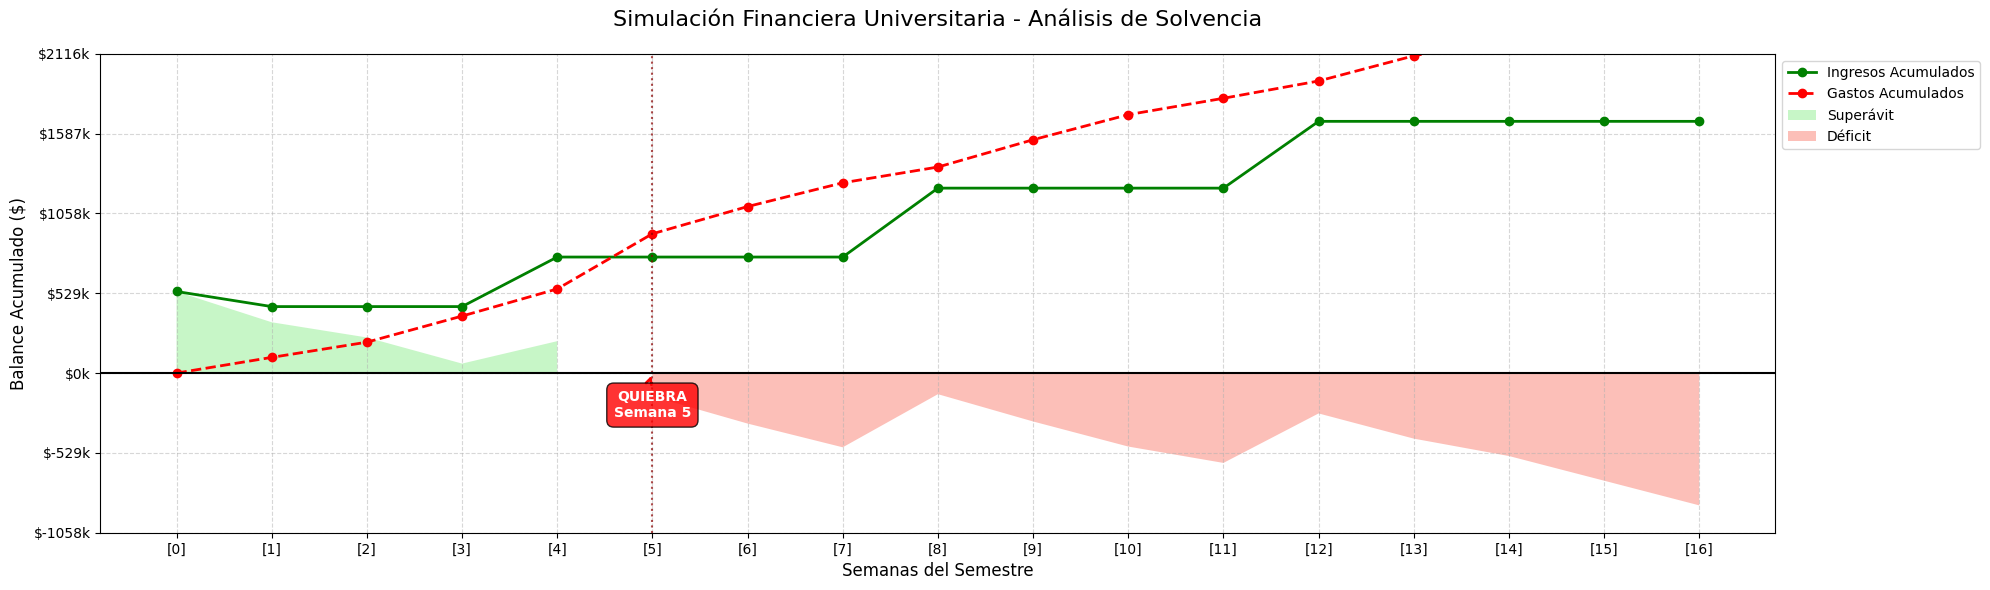

In [52]:
financial_evolution.run_simulation()
financial_evolution.plot_results()
plt.show()

In [53]:
financial_evolution.generate_report()

Métrica,Valor,Detalle
Estado Financiero,EN QUIEBRA (Semana 5),Situación al final del semestre
Balance Final,"$-876,751",Ingresos - Gastos totales
Ingresos Totales,"$1,668,143","Incluye 400,000/mes + extras"
Gastos Totales,"$2,544,894","Promedio semanal: $162,731"
Máximo Déficit,"$-876,751",Valor más negativo alcanzado
Composición de Gastos,"Almuerzos: 3x/sem × $16,500Transporte: 5d/sem × $6,800 (ida/vuelta)Meriendas: Sí ($5,000-15,000) Gastosextras: 40% prob ($50,000-100,000)Emergencias: 10% prob ($100,000-300,000)",Estructura de costos semanales
Recomendaciones,Reducir gastos variablesBuscar ingresos adicionalesGastos semanales muy altos vs ingresos,Acciones sugeridas
